In [113]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#MÔ HÌNH U-Net VỚI TẬP DỮ LIỆU POLYPS


#Xây dựng U-Net bằng keras

In [114]:
import os
import cv2
import numpy as np
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from keras.layers import concatenate
from keras.models import Model, load_model
from keras.callbacks import LearningRateScheduler
from keras import backend as K
import tensorflow as tf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

%matplotlib inline

#Load và định dạng dữ liệu
372 ảnh train và 7 ảnh test
 thay đổi kích thước ảnh về 256

In [115]:
image_path = sorted(os.listdir("/content/drive/MyDrive/Colab/Polyps/Input"))
label_path = sorted(os.listdir("/content/drive/MyDrive/Colab/Polyps/Target"))

In [116]:
len(image_path)==len(label_path)

True

In [117]:
IMAGE_SIZE = 256

In [118]:

def load_images(inputdir, inputpath):
    imglist = []

    for i in range(len(inputpath)):
        img = cv2.imread(inputdir+inputpath[i], cv2.IMREAD_ANYCOLOR)
        img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation = cv2.INTER_AREA)
        imglist.append(img)

    return imglist

In [119]:
def segment(label):
    labels = []

    for i in range(len(label)):
        tmp = label[i]
        for j in range(IMAGE_SIZE):
          for k in range(IMAGE_SIZE):
            if tmp[j,k] != 0:
                tmp[j,k] = 200

        labels.append(tmp)

    return labels

In [120]:
image = load_images("/content/drive/MyDrive/Colab/Polyps/Input/", image_path)
before_label = load_images("/content/drive/MyDrive/Colab/Polyps/Target/", label_path)

after_label = segment(before_label)

visualize

In [121]:
from google.colab.patches import cv2_imshow

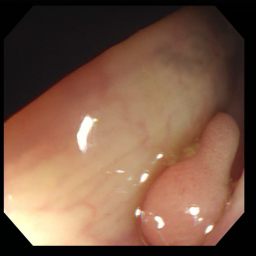

In [122]:
cv2_imshow(image[50])

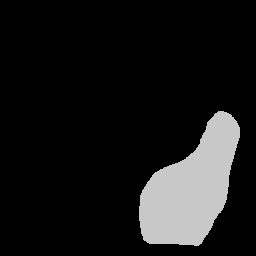

In [123]:
cv2_imshow(after_label[50])

Chuẩn hóa trước khi đưa vào mô hình

In [124]:
image /= np.max(image)
after_label /= np.max(after_label)

#Xây dựng mô hình


In [125]:
def Unet():
    input_img = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

    enc1 = Conv2D(64, kernel_size=3, strides=1, activation="relu", padding="same")(input_img)
    enc1 = BatchNormalization()(enc1)
    enc1 = Conv2D(64, kernel_size=3, strides=1, activation="relu", padding="same")(enc1)
    enc1 = BatchNormalization()(enc1)
    down1 = MaxPooling2D(pool_size=2, strides=2)(enc1)

    enc2 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(down1)
    enc2 = BatchNormalization()(enc2)
    enc2 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(enc2)
    enc2 = BatchNormalization()(enc2)
    down2 = MaxPooling2D(pool_size=2, strides=2)(enc2)

    enc3 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(down2)
    enc3 = BatchNormalization()(enc3)
    enc3 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(enc3)
    enc3 = BatchNormalization()(enc3)
    down3 = MaxPooling2D(pool_size=2, strides=2)(enc3)

    enc4 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(down3)
    enc4 = BatchNormalization()(enc4)
    enc4 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(enc4)
    enc4 = BatchNormalization()(enc4)
    down4 = MaxPooling2D(pool_size=2, strides=2)(enc4)

    enc5 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(down4)
    enc5 = BatchNormalization()(enc5)
    enc5 = Conv2D(1024, kernel_size=3, strides=1, activation="relu", padding="same")(enc5)
    enc5 = BatchNormalization()(enc5)

    up4 = UpSampling2D(size=2)(enc5)
    dec4 = concatenate([up4, enc4], axis=-1)
    dec4 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)
    dec4 = Conv2D(512, kernel_size=3, strides=1, activation="relu", padding="same")(dec4)
    dec4 = BatchNormalization()(dec4)

    up3 = UpSampling2D(size=2)(dec4)
    dec3 = concatenate([up3, enc3], axis=-1)
    dec3 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)
    dec3 = Conv2D(256, kernel_size=3, strides=1, activation="relu", padding="same")(dec3)
    dec3 = BatchNormalization()(dec3)

    up2 = UpSampling2D(size=2)(dec3)
    dec2 = concatenate([up2, enc2], axis=-1)
    dec2 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)
    dec2 = Conv2D(128, kernel_size=3, strides=1, activation="relu", padding="same")(dec2)
    dec2 = BatchNormalization()(dec2)

    up1 = UpSampling2D(size=2)(dec2)
    dec1 = concatenate([up1, enc1], axis=-1)
    dec1 = Conv2D(64, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)
    dec1 = Conv2D(64, kernel_size=3, strides=1, activation="relu", padding="same")(dec1)
    dec1 = BatchNormalization()(dec1)

    dec1 = Conv2D(1, kernel_size=1, strides=1, activation="sigmoid", padding="same")(dec1)

    model = Model(input_img, dec1)

    return model

In [126]:
model = Unet()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_57 (Conv2D)             (None, 256, 256, 64  1792        ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_54 (BatchN  (None, 256, 256, 64  256        ['conv2d_57[0][0]']              
 ormalization)                  )                                                           

#Train mô hình, dùng adam để tối ưu và giảm learning rate sau mỗi 10 epoch
train qua 45 epoch

In [127]:
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [128]:
X_train, X_val, T_train, T_val = train_test_split(image, after_label, test_size=0.2)

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[dice_coef])

initial_learningrate=2e-3

def lr_decay(epoch):
    if epoch < 10:
        return initial_learningrate
    else:
        return initial_learningrate * 0.99 ** epoch

training = model.fit(X_train, T_train,epochs=45, batch_size=12, shuffle=True, validation_data=(X_val, T_val),callbacks=[LearningRateScheduler(lr_decay)])

Epoch 1/45
25/25 [==============================] - 32s 785ms/step - loss: 0.6473 - dice_coef: 0.1362 - val_loss: 14.1165 - val_dice_coef: 0.1343 - lr: 0.0020
Epoch 2/45
25/25 [==============================] - 19s 772ms/step - loss: 0.4207 - dice_coef: 0.1456 - val_loss: 1.2397 - val_dice_coef: 2.5606e-05 - lr: 0.0020
Epoch 3/45
25/25 [==============================] - 19s 781ms/step - loss: 0.3137 - dice_coef: 0.1551 - val_loss: 13.6603 - val_dice_coef: 0.1347 - lr: 0.0020
Epoch 4/45
25/25 [==============================] - 20s 791ms/step - loss: 0.2627 - dice_coef: 0.1562 - val_loss: 3.6999 - val_dice_coef: 0.1686 - lr: 0.0020
Epoch 5/45
25/25 [==============================] - 20s 804ms/step - loss: 0.2339 - dice_coef: 0.1694 - val_loss: 0.6874 - val_dice_coef: 0.0035 - lr: 0.0020
Epoch 6/45
25/25 [==============================] - 20s 808ms/step - loss: 0.2190 - dice_coef: 0.1896 - val_loss: 0.4410 - val_dice_coef: 0.0740 - lr: 0.0020
Epoch 7/45
25/25 [============================

##Quá trình huấn luyện mô hình thể hiện bằng đồ thị

link tham khảo: https://www.machinelearningnuggets.com/image-segmentation-with-u-net-define-u-net-model-from-scratch-in-keras-and-tensorflow/

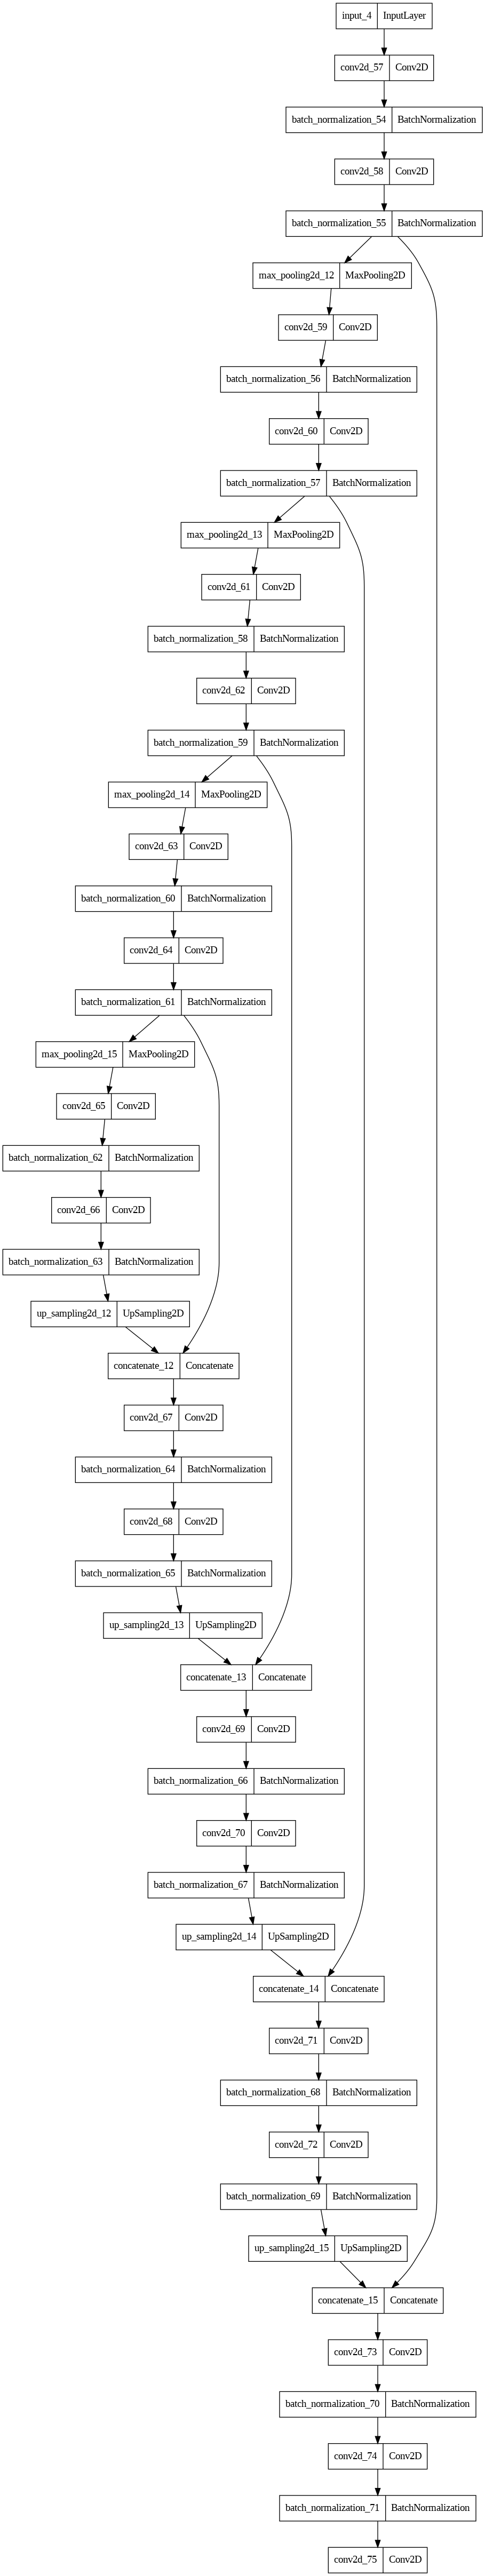

In [129]:
tf.keras.utils.plot_model(model, "model.png")

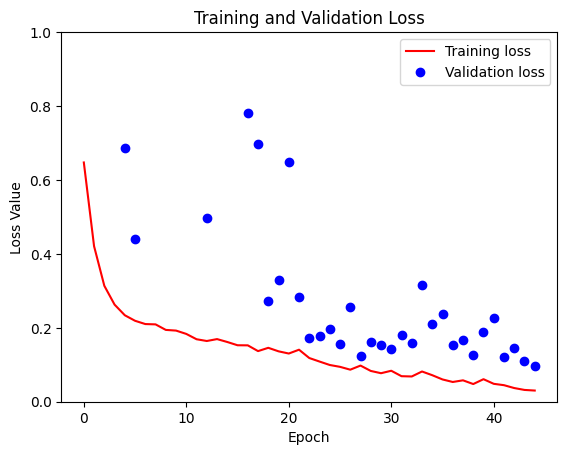

In [130]:
loss = training.history['loss']
val_loss = training.history['val_loss']

plt.figure()
plt.plot( loss, 'r', label='Training loss')
plt.plot( val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Test mô hình, dùng tập dữ liệu test gồm 7 ảnh, và đánh giá dựa trên số pixel sai khác

In [131]:
test_path = sorted(os.listdir("/content/drive/MyDrive/Colab/Polyps/XTest"))
test_image = load_images("/content/drive/MyDrive/Colab/Polyps/XTest/", test_path)

test_image /= np.max(test_image)
results = model.predict(test_image,verbose=1)

1/1 [==============================] - 0s 335ms/step


In [132]:
truth_path = sorted(os.listdir("/content/drive/MyDrive/Colab/Polyps/YTest"))
truth = load_images("/content/drive/MyDrive/Colab/Polyps/YTest/", truth_path)
y_truth = segment(truth)
y_pred = list(results)

# Đánh giá mô hình U-Net
Đánh giá mô hình giống mô hình phân lớp nhưng trên từng pixel



####Định dạng lại ảnh đã phân vùng

In [133]:
for k in range(len(y_truth)):
  for i in range(IMAGE_SIZE):
    for j in range(IMAGE_SIZE):
      if y_pred[k][i,j] > 0.5:
        y_pred[k][i,j] = 200
      else:
        y_pred[k][i,j] = 0


####Tính precision, recall, accuracy, f1-score trên ảnh test số 7 trong tập test

In [134]:
t = y_truth[6].flatten()
p = y_pred[6].flatten()
for i in range(len(t)):
  if t[i] > 0:
    t[i] = 1
  if p[i] > 0:
    p[i] = 1

In [135]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

# Tính accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(t, p)
print('Accuracy: %f' % accuracy)
# Tính precision tp / (tp + fp)
precision = precision_score(t, p, average='macro')
print('Precision: %f' % precision)
# Tính recall: tp / (tp + fn)
recall = recall_score(t, p, average='macro')
print('Recall: %f' % recall)
# Tính f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(t, p, average='macro')
print('F1 score: %f' % f1)
# Tính Area under ROC
auc = roc_auc_score(t, p, multi_class='ovr')
print('ROC AUC: %f' % auc)
# Tính confusion matrix
matrix = confusion_matrix(t, p)
print(matrix)

Accuracy: 0.996231
Precision: 0.992930
Recall: 0.924778
F1 score: 0.956199
ROC AUC: 0.924778
[[63971    14]
 [  233  1318]]


#### accuracy trên toàn bộ tập ảnh test

In [136]:
# tính theo cách thủ công
for i in range(len(y_truth)):
  count = 0
  tem1 = y_pred[i].flatten()
  tem2 = y_truth[i].flatten()
  l = len(tem1)
  for j in range(l):
    if tem1[j] != tem2[j]:
      count += 1
  print('image  ', i, "has accuracy: ", (1 - count/l)*100, '%\n')


image   0 has accuracy:  99.06768798828125 %

image   1 has accuracy:  99.42779541015625 %

image   2 has accuracy:  99.7039794921875 %

image   3 has accuracy:  98.4100341796875 %

image   4 has accuracy:  99.6368408203125 %

image   5 has accuracy:  99.5391845703125 %

image   6 has accuracy:  99.62310791015625 %



# visualize

Hiển thị ảnh thứ n+1 trong 7 ảnh test, ở đây dùng n = 6 là ảnh số 7

predict


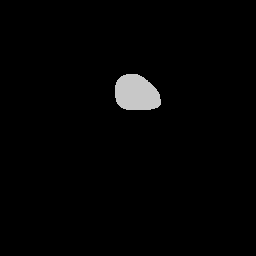

truth


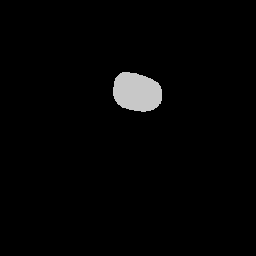

In [137]:
n = 6
print("predict")
cv2_imshow(y_pred[n])
print('truth')
cv2_imshow(y_truth[n])